Preprocess

In [9]:
# %% [markdown]
# ## Corrected Preprocessing Pipeline (with datetime-dtype fix)

# %% [code]
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# %% [code]
# 1. Load the dataset
df = pd.read_csv(r'C:\Users\User\Downloads\weather air pollution data\pollution_data.csv')

# %% [code]
# 2. Parse dates (ensure datetime dtype before using .dt)
df['datetime'] = pd.to_datetime(df['date'], errors='raise')
df.drop(columns=['date'], inplace=True)

# %% [code]
# Sanity check
print("datetime dtype:", df['datetime'].dtype)  # should be datetime64[ns]

# %% [code]
# 3. Canonicalize wind-direction, then one-hot encode (dropping first to avoid collinearity)
df['wnd_dir'] = df['wnd_dir'].replace('cv', 'SW')
df = pd.get_dummies(df, columns=['wnd_dir'], drop_first=False).astype(int)
# Now you have wnd_dir_NW, wnd_dir_SE, wnd_dir_SW

# %% [code]
# 4. Create lagged pollution and rolling-mean features
df['pollution_lag1']      = df['pollution'].shift(1)
df['pollution_lag2']      = df['pollution'].shift(2)
df['pollution_roll_mean3'] = df['pollution'].rolling(window=3).mean()

# %% [code]
# 5. Extract time components
# Re-ensure datetime dtype if re-running cells
df['datetime'] = pd.to_datetime(df['datetime'])

df['hour']   = df['datetime'].dt.hour
df['day']    = df['datetime'].dt.day
df['month']  = df['datetime'].dt.month
df['year']   = df['datetime'].dt.year

# %% [code]
# 6. Engineer a “years since start” feature
start_year = df['year'].min()
df['years_since_start'] = df['year'] - start_year

# %% [code]
# 7. Cyclical encoding for hour, day, and month
df['hour_sin']   = np.sin(2 * np.pi * df['hour']  / 24)
df['hour_cos']   = np.cos(2 * np.pi * df['hour']  / 24)
df['day_sin']    = np.sin(2 * np.pi * df['day']   / 31)
df['day_cos']    = np.cos(2 * np.pi * df['day']   / 31)
df['month_sin']  = np.sin(2 * np.pi * df['month']/ 12)
df['month_cos']  = np.cos(2 * np.pi * df['month']/ 12)

# %% [code]
# 8. Drop NaNs introduced by shifting/rolling
df.dropna(inplace=True)

# %% [markdown]
# ### Define features & target

# %% [code]
target     = 'pollution'
drop_cols  = ['datetime', 'pollution', 'year']
features   = [c for c in df.columns if c not in drop_cols]

X = df[features]
y = df[target]

# %% [markdown]
# ### Temporal train/test split (80% train / 20% test)

# %% [code]
n         = len(df)
train_sz  = int(n * 0.8)

X_train = X.iloc[:train_sz].copy()
X_test  = X.iloc[train_sz:].copy()
y_train = y.iloc[:train_sz]
y_test  = y.iloc[train_sz:]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# %% [markdown]
# ### Feature scaling (fit on train only)

# %% [code]
cols_to_scale = [
    'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
    'pollution_lag1', 'pollution_lag2', 'pollution_roll_mean3'
]

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale])

# %% [code]
# 9. Final sanity checks
print("Scaled means (train):\n", X_train[cols_to_scale].mean().round(3))
print("\nScaled stds  (train):\n", X_train[cols_to_scale].std().round(3))

print("\nFeatures:\n", X_train.columns.tolist())
print("\nTrain datetime range:", df.iloc[:train_sz]['datetime'].min(),
      "to", df.iloc[:train_sz]['datetime'].max())
print("Test  datetime range:", df.iloc[train_sz:]['datetime'].min(),
      "to", df.iloc[train_sz:]['datetime'].max())


datetime dtype: datetime64[ns]
Train size: 35038, Test size: 8760
Scaled means (train):
 dew                     0.0
temp                   -0.0
press                  -0.0
wnd_spd                 0.0
snow                   -0.0
rain                    0.0
pollution_lag1         -0.0
pollution_lag2         -0.0
pollution_roll_mean3    0.0
dtype: float64

Scaled stds  (train):
 dew                     1.0
temp                    1.0
press                   1.0
wnd_spd                 1.0
snow                    1.0
rain                    1.0
pollution_lag1          1.0
pollution_lag2          1.0
pollution_roll_mean3    1.0
dtype: float64

Features:
 ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'wnd_dir_NE', 'wnd_dir_NW', 'wnd_dir_SE', 'wnd_dir_SW', 'pollution_lag1', 'pollution_lag2', 'pollution_roll_mean3', 'hour', 'day', 'month', 'years_since_start', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']

Train datetime range: 2010-01-02 02:00:00 to 2013-12-31

RF


--- Base RF Performance ---
MAE: 2.263760273972603
R² : 0.9956851733426385


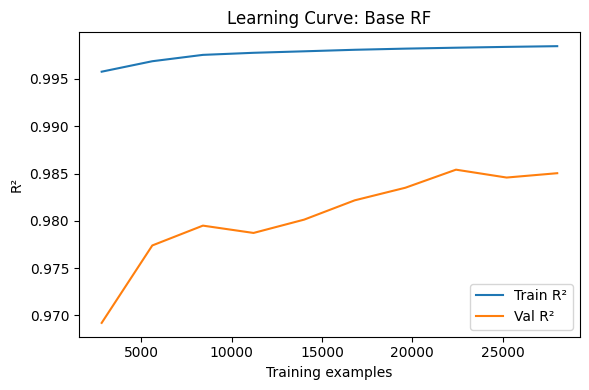

Fitting 3 folds for each of 18 candidates, totalling 54 fits

--- Tuned RF ---
Best params: {'max_depth': 20, 'max_features': None, 'n_estimators': 200}
CV R²     : 0.9846825830927181

Tuned RF MAE: 2.2317149637774025
Tuned RF R² : 0.9956962009996897


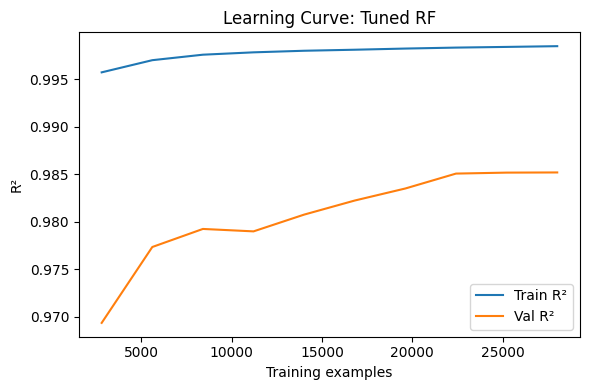

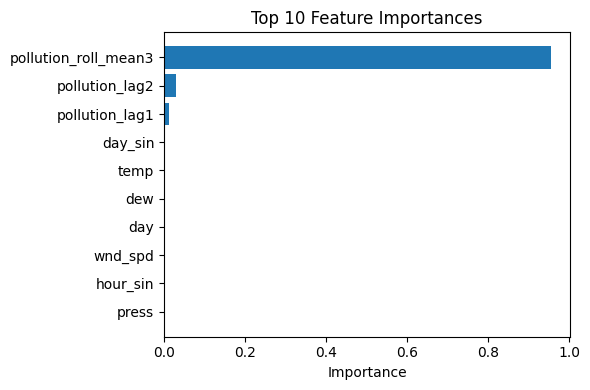

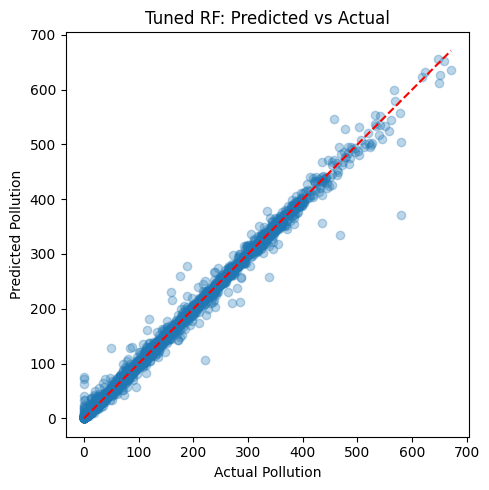

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error, r2_score

# 9) Base RF
base_rf = RandomForestRegressor(random_state=42)
base_rf.fit(X_train, y_train)
yb_base = base_rf.predict(X_test)

print("\n--- Base RF Performance ---")
print("MAE:", mean_absolute_error(y_test, yb_base))
print("R² :", r2_score(y_test, yb_base))

# 10) Learning curve: Base RF
train_sizes, tr_scores, val_scores = learning_curve(
    base_rf, X_train, y_train, cv=5, scoring='r2',
    train_sizes=np.linspace(0.1,1.0,10), n_jobs=-1, shuffle=True, random_state=42
)
plt.figure(figsize=(6,4))
plt.plot(train_sizes, tr_scores.mean(1), label='Train R²')
plt.plot(train_sizes, val_scores.mean(1), label='Val R²')
plt.title("Learning Curve: Base RF")
plt.xlabel("Training examples")
plt.ylabel("R²")
plt.legend()
plt.tight_layout()
plt.show()

# 11) Hyperparameter tuning
param_grid = {
    'n_estimators': [100,200],
    'max_depth'   : [None,10,20],
    'max_features': ['sqrt','log2', None]
}
grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1, error_score='raise'
)
grid.fit(X_train, y_train)

tuned_rf = grid.best_estimator_
print("\n--- Tuned RF ---")
print("Best params:", grid.best_params_)
print("CV R²     :", grid.best_score_)

# 12) Evaluate tuned RF
yb_tuned = tuned_rf.predict(X_test)
print("\nTuned RF MAE:", mean_absolute_error(y_test, yb_tuned))
print("Tuned RF R² :", r2_score(y_test, yb_tuned))

# 13) Learning curve: Tuned RF
t_ts, t_tr, t_val = learning_curve(
    tuned_rf, X_train, y_train, cv=5, scoring='r2',
    train_sizes=np.linspace(0.1,1.0,10), n_jobs=-1, shuffle=True, random_state=42
)
plt.figure(figsize=(6,4))
plt.plot(t_ts, t_tr.mean(1), label='Train R²')
plt.plot(t_ts, t_val.mean(1), label='Val R²')
plt.title("Learning Curve: Tuned RF")
plt.xlabel("Training examples")
plt.ylabel("R²")
plt.legend()
plt.tight_layout()
plt.show()

# 14) Feature importances (top 10)
importances = tuned_rf.feature_importances_
idx = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(6,4))
plt.barh(range(10), importances[idx][::-1], align='center')
plt.yticks(range(10), X_train.columns[idx][::-1])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 15) Predicted vs Actual (tuned)
plt.figure(figsize=(5,5))
plt.scatter(y_test, yb_tuned, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.title("Tuned RF: Predicted vs Actual")
plt.xlabel("Actual Pollution")
plt.ylabel("Predicted Pollution")
plt.tight_layout()
plt.show()

In [4]:
# Base RF
base_rf.fit(X_train, y_train)
print("Base RF Train  R²:", base_rf.score(X_train, y_train))
print("Base RF Test   R²:", base_rf.score(X_test,  y_test))

# Tuned RF
tuned_rf.fit(X_train, y_train)
print("Tuned RF Train R²:", tuned_rf.score(X_train, y_train))
print("Tuned RF Test  R²:", tuned_rf.score(X_test,  y_test))

Base RF Train  R²: 0.9985098924254052
Base RF Test   R²: 0.9956851733426385
Tuned RF Train R²: 0.9984595536777333
Tuned RF Test  R²: 0.9956962009996897


In [5]:
from sklearn.model_selection import cross_val_score

cv_r2 = cross_val_score(tuned_rf, X_train, y_train,
                        cv=5, scoring='r2', n_jobs=-1)
print("5-fold CV R² on training set:",
      f"{cv_r2.mean():.4f} ± {cv_r2.std():.4f}")


5-fold CV R² on training set: 0.9851 ± 0.0085


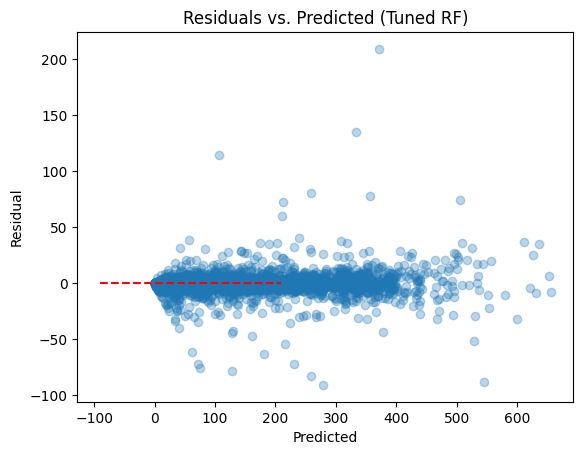

In [6]:
import matplotlib.pyplot as plt

resid = y_test - tuned_rf.predict(X_test)
plt.scatter(tuned_rf.predict(X_test), resid, alpha=0.3)
plt.hlines(0, resid.min(), resid.max(), linestyle='--', color='r')
plt.xlabel("Predicted"); plt.ylabel("Residual")
plt.title("Residuals vs. Predicted (Tuned RF)")
plt.show()


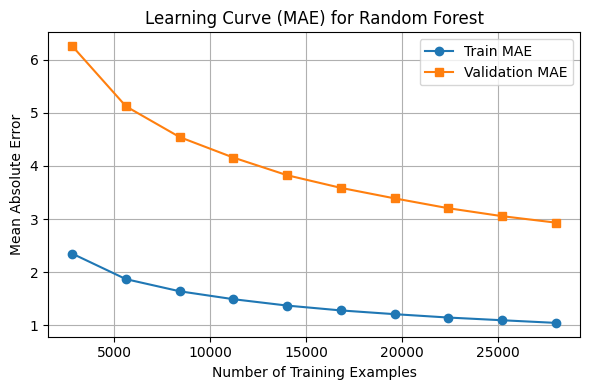

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# Compute learning curve using MAE (negative during CV)
train_sizes, train_scores, val_scores = learning_curve(
    tuned_rf, X_train, y_train, cv=5, 
    scoring='neg_mean_absolute_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

# Convert negative MAE scores to positive MAE
train_mae = -np.mean(train_scores, axis=1)
val_mae = -np.mean(val_scores, axis=1)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mae, marker='o', label='Train MAE')
plt.plot(train_sizes, val_mae, marker='s', label='Validation MAE')
plt.title("Learning Curve (MAE) for Random Forest")
plt.xlabel("Number of Training Examples")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np
import joblib

# === Assume these objects exist in your namespace from training:
# tuned_rf (your trained RandomForestRegressor)
# scaler  (your StandardScaler fitted on training data)
# features (list of feature names used by the model)

# 1) Save the model and scaler to disk
joblib.dump(tuned_rf, 'rf_tuned_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
print("Model and scaler saved to 'rf_tuned_model.joblib' and 'scaler.joblib'")

Model and scaler saved to 'rf_tuned_model.joblib' and 'scaler.joblib'


In [18]:
import os
import joblib

# 1. Ensure the target directory exists
model_dir = r"C:/my_models"
os.makedirs(model_dir, exist_ok=True)

# 2. Save each artifact
joblib.dump(tuned_rf,    os.path.join(model_dir, "rf_tuned_model.joblib"))
joblib.dump(scaler,      os.path.join(model_dir, "scaler.joblib"))
joblib.dump(features,    os.path.join(model_dir, "features.joblib"))
joblib.dump(start_year,  os.path.join(model_dir, "start_year.joblib"))

print(f"Artifacts saved to {model_dir}")


Artifacts saved to C:/my_models


Adaboost

Best tuned params: {'estimator__max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 200}
Base AdaBoost Evaluation on Test Set → R²: 0.921, RMSE: 26.23, MAE: 19.07
Tuned AdaBoost Evaluation on Test Set → R²: 0.955, RMSE: 19.77, MAE: 12.25


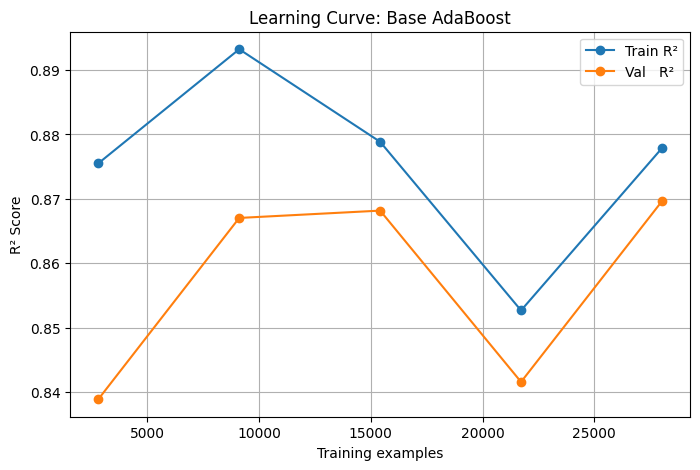

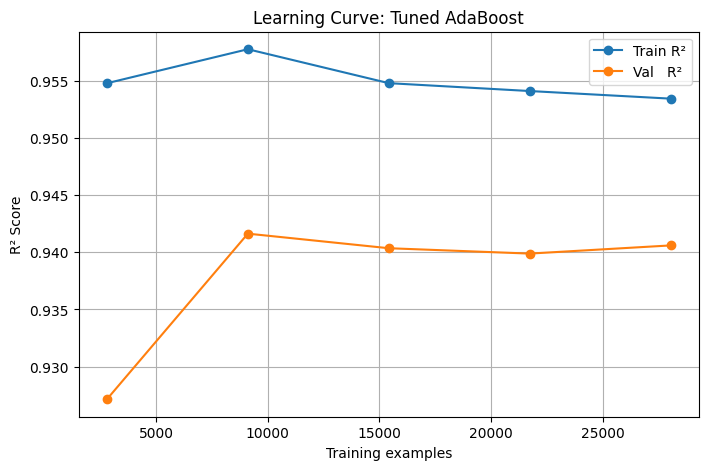

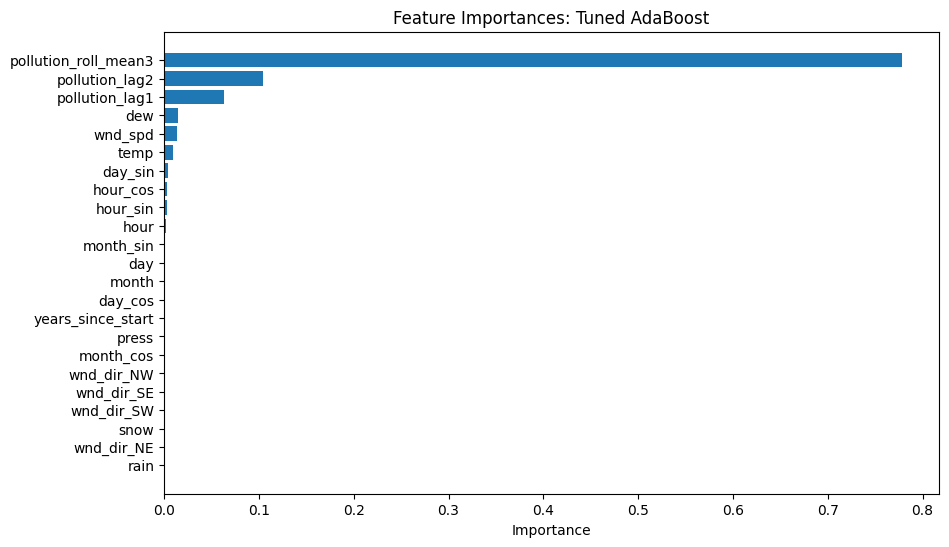

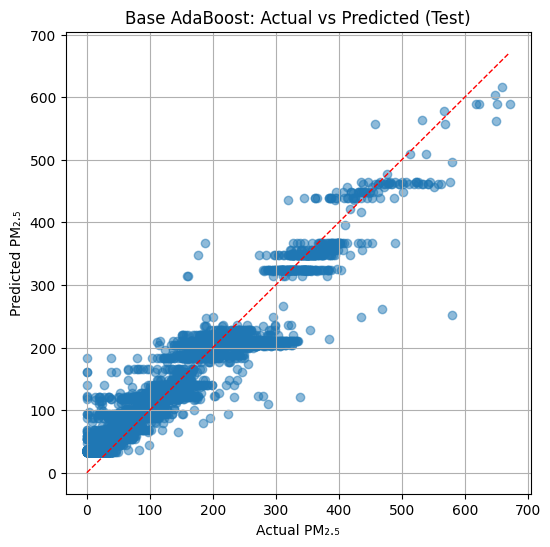

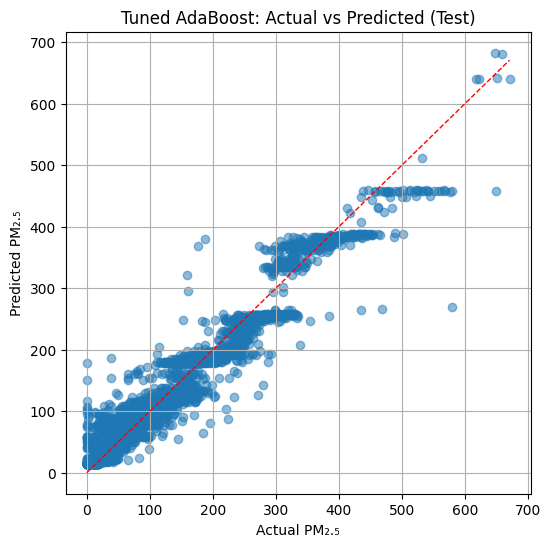

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assumes X_train, X_test, y_train, y_test are already defined

# 1) Base AdaBoost
base_ada = AdaBoostRegressor(random_state=42)
base_ada.fit(X_train, y_train)

# 2) Tuned AdaBoost via GridSearch (use 'estimator' param name)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [2, 3, 4]
}
grid = GridSearchCV(
    AdaBoostRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        random_state=42
    ),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid.fit(X_train, y_train)
best_ada = grid.best_estimator_
print("Best tuned params:", grid.best_params_)

# 3) Evaluate models
def evaluate_model(est, name):
    y_pred = est.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} Evaluation on Test Set → R²: {r2:.3f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

evaluate_model(base_ada,  "Base AdaBoost")
evaluate_model(best_ada,  "Tuned AdaBoost")

# 4) Learning curves
def plot_learning_curve(estimator, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=5, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean  = np.mean(test_scores, axis=1)
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', label='Train R²')
    plt.plot(train_sizes, test_mean,  'o-', label='Val   R²')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(base_ada, 'Learning Curve: Base AdaBoost')
plot_learning_curve(best_ada, 'Learning Curve: Tuned AdaBoost')

# 5) Feature importances of tuned model
importances = best_ada.feature_importances_
indices = np.argsort(importances)[::-1]
feat_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), feat_names[indices])
plt.xlabel('Importance')
plt.title('Feature Importances: Tuned AdaBoost')
plt.gca().invert_yaxis()
plt.show()

# 6) Actual vs. Predicted plots
def plot_actual_vs_pred(est, name):
    y_pred = est.predict(X_test)
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=1)
    plt.xlabel('Actual PM₂.₅')
    plt.ylabel('Predicted PM₂.₅')
    plt.title(f'{name}: Actual vs Predicted (Test)')
    plt.grid(True)
    plt.show()

plot_actual_vs_pred(base_ada, "Base AdaBoost")
plot_actual_vs_pred(best_ada, "Tuned AdaBoost")


KNN 

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tuned KNN params: {'n_neighbors': 9, 'weights': 'distance'}


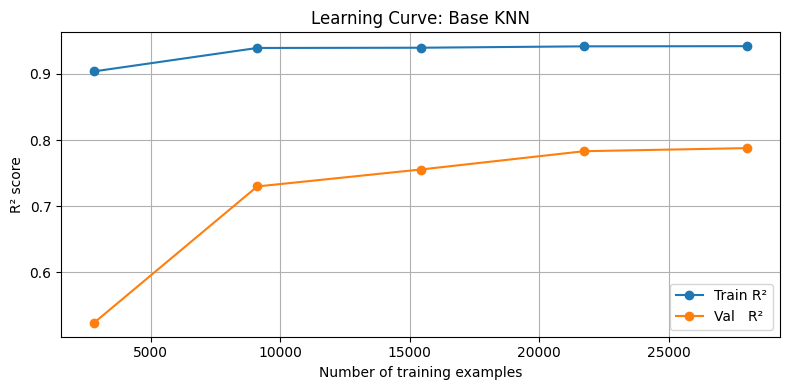

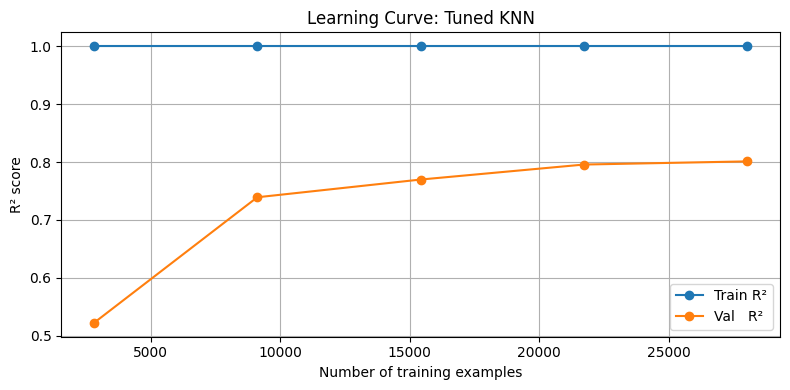

Base KNN → R²: 0.824, RMSE: 39.28, MAE: 28.63
Tuned KNN → R²: 0.840, RMSE: 37.46, MAE: 27.34


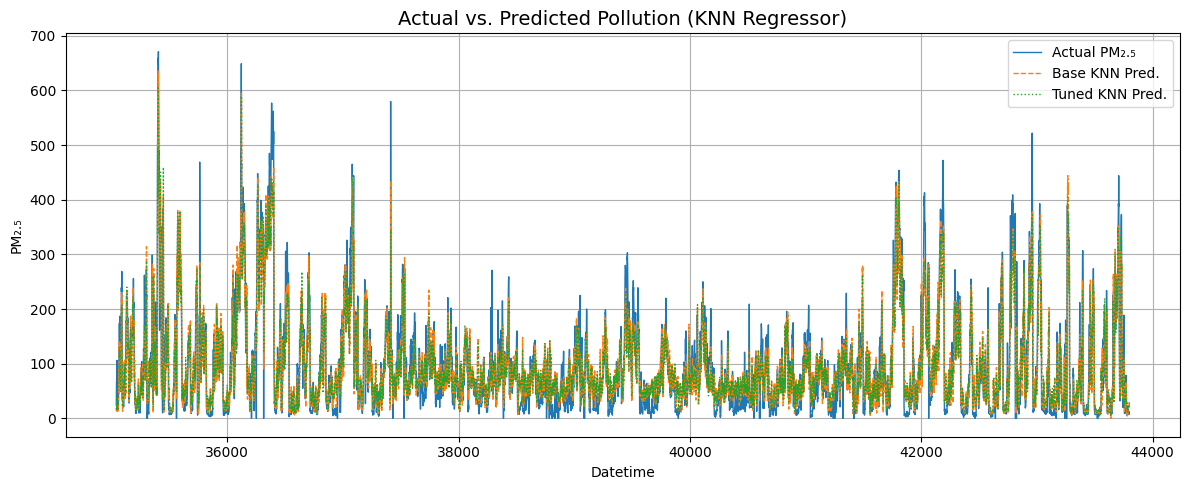

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ── Assumes X_train, X_test, y_train, y_test are already defined ────────────

# 1) Train the base KNN regressor
base_knn = KNeighborsRegressor()
base_knn.fit(X_train, y_train)

# 2) Hyperparameter tuning via GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_knn.fit(X_train, y_train)
tuned_knn = grid_knn.best_estimator_

print("Tuned KNN params:", grid_knn.best_params_)

# 3) Plot learning curves for both models
def plot_learning_curve(estimator, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_train, y_train,
        cv=5, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    val_mean   = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, train_mean, marker='o', label='Train R²')
    plt.plot(train_sizes, val_mean,   marker='o', label='Val   R²')
    plt.title(title)
    plt.xlabel('Number of training examples')
    plt.ylabel('R² score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(base_knn,  'Learning Curve: Base KNN')
plot_learning_curve(tuned_knn, 'Learning Curve: Tuned KNN')

# 4) Evaluate on the test set
y_pred_base  = base_knn.predict(X_test)
y_pred_tuned = tuned_knn.predict(X_test)

def print_eval(name, y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"{name} → R²: {r2:.3f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

print_eval("Base KNN",  y_test, y_pred_base)
print_eval("Tuned KNN", y_test, y_pred_tuned)

# 5) Actual vs. Predicted over time (both models on one chart)
#    Assumes y_test is a pandas Series indexed by datetime
dt_index = y_test.index

plt.figure(figsize=(12, 5))
plt.plot(dt_index, y_test,           label='Actual PM₂.₅',       color='tab:blue',   linewidth=1)
plt.plot(dt_index, y_pred_base,     '--', label='Base KNN Pred.',  color='tab:orange', linewidth=1)
plt.plot(dt_index, y_pred_tuned,    ':',  label='Tuned KNN Pred.', color='tab:green',  linewidth=1)
plt.title('Actual vs. Predicted Pollution (KNN Regressor)', fontsize=14)
plt.xlabel('Datetime')
plt.ylabel('PM₂.₅')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


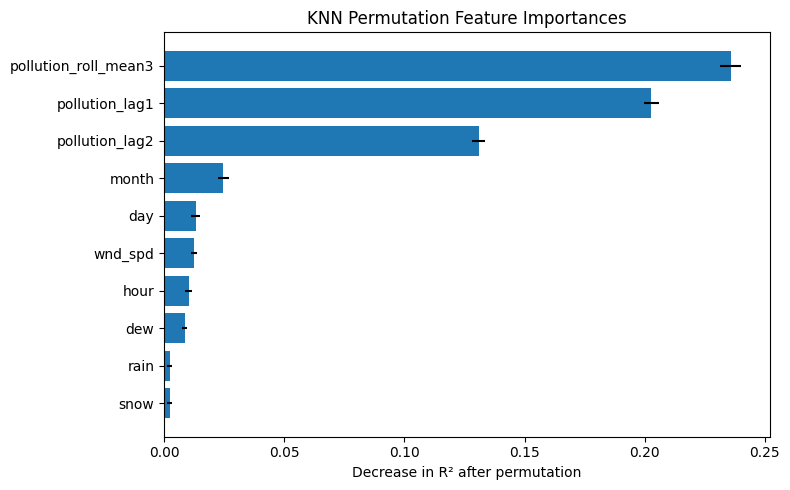

In [31]:
from sklearn.inspection import permutation_importance

# 6) Permutation importance on the test set
result = permutation_importance(
    tuned_knn,         # or base_knn if you prefer
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='r2'
)

# 7) Extract and sort
importances = result.importances_mean
stds        = result.importances_std
indices     = np.argsort(importances)[::-1]

# 8) Plot the top 10 features
top_n = 10
plt.figure(figsize=(8,5))
plt.barh(
    np.arange(top_n)[::-1],
    importances[indices][:top_n],
    xerr=stds[indices][:top_n],
    align='center'
)
plt.yticks(
    np.arange(top_n)[::-1],
    X_train.columns[indices][:top_n]
)
plt.xlabel("Decrease in R² after permutation")
plt.title("KNN Permutation Feature Importances")
plt.tight_layout()
plt.show()


elastic net

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Tuned ElasticNet params: {'alpha': 1.0, 'l1_ratio': 0.8}


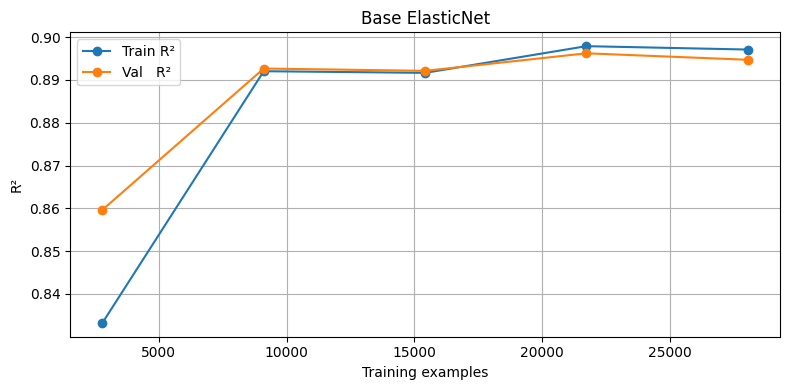

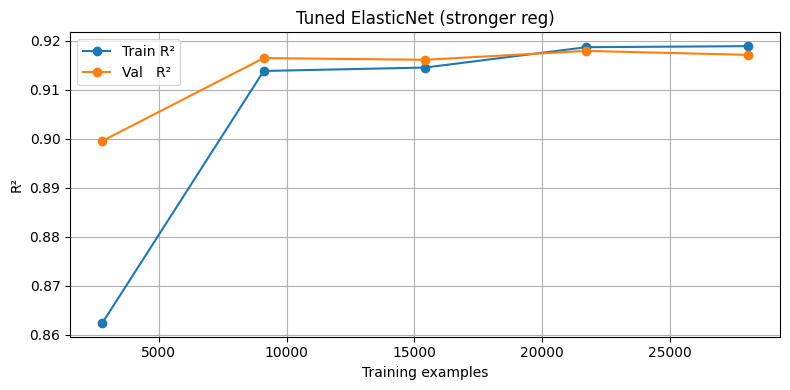

Base ElasticNet → R²: 0.914, RMSE: 27.41, MAE: 17.74
Tuned ElasticNet → R²: 0.936, RMSE: 23.69, MAE: 14.15


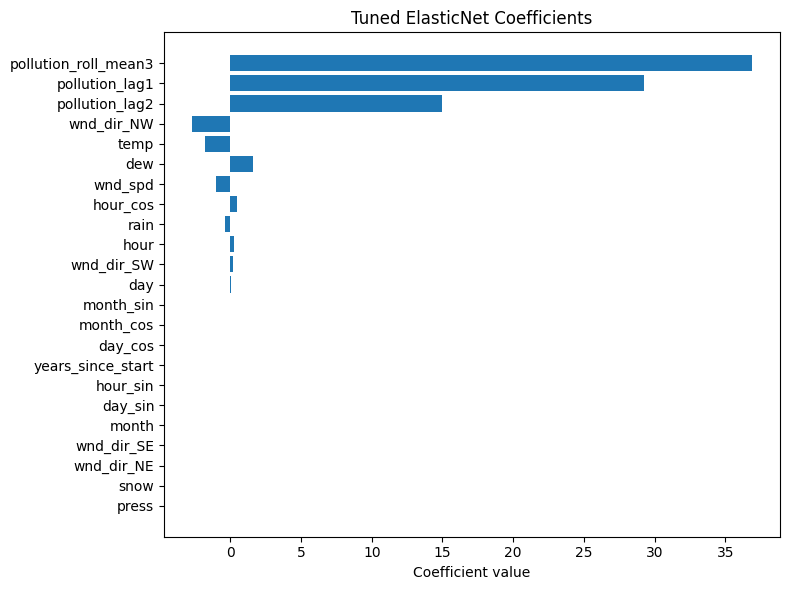

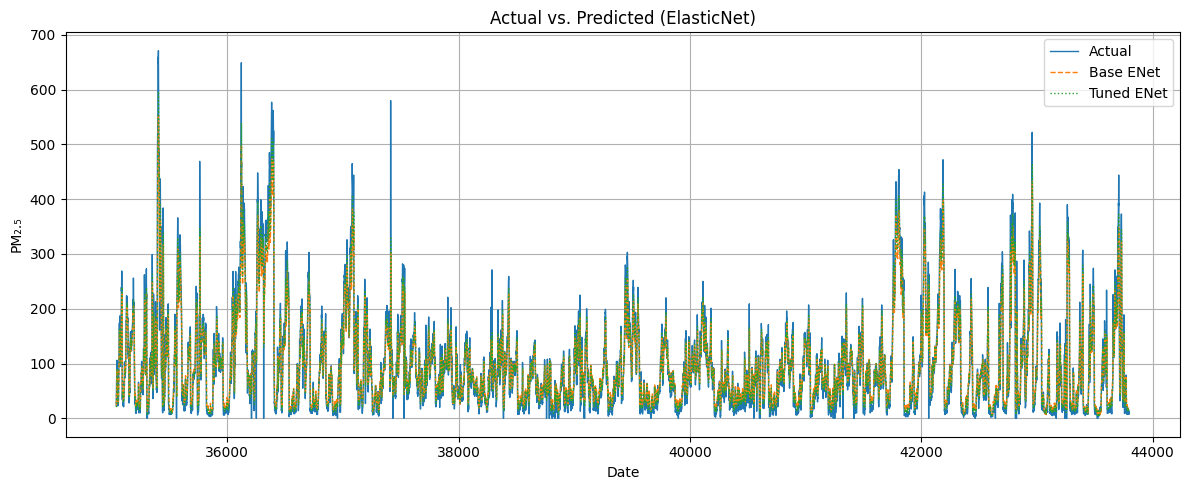

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ── Assumes X_train, X_test, y_train, y_test are already defined ────────────

# 1) Base ElasticNet
base_en = ElasticNet(random_state=42)
base_en.fit(X_train, y_train)

# 2) Tuned ElasticNet with stronger regularization
param_grid = {
    'alpha':    [1.0, 5.0, 10.0, 50.0],    # larger values → more penalty
    'l1_ratio': [0.2, 0.5, 0.8],           # avoid extremes
}
grid_en = GridSearchCV(
    ElasticNet(random_state=42),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_en.fit(X_train, y_train)
tuned_en = grid_en.best_estimator_

print("Tuned ElasticNet params:", grid_en.best_params_)

# 3) Learning curves
def plot_learning_curve(est, title):
    train_sizes, train_scores, val_scores = learning_curve(
        est, X_train, y_train,
        cv=5, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    plt.figure(figsize=(8,4))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train R²')
    plt.plot(train_sizes, val_scores.mean(axis=1),   'o-', label='Val   R²')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('R²')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(base_en,  'Base ElasticNet')
plot_learning_curve(tuned_en, 'Tuned ElasticNet (stronger reg)')

# 4) Evaluate on test set
def eval_model(name, y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"{name} → R²: {r2:.3f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

y_pred_base  = base_en.predict(X_test)
y_pred_tuned = tuned_en.predict(X_test)

eval_model("Base ElasticNet",  y_test, y_pred_base)
eval_model("Tuned ElasticNet", y_test, y_pred_tuned)

# 5) Coefficients
coefs = tuned_en.coef_
feat  = X_train.columns
order = np.argsort(np.abs(coefs))[::-1]

plt.figure(figsize=(8,6))
plt.barh(feat[order], coefs[order])
plt.title("Tuned ElasticNet Coefficients")
plt.xlabel("Coefficient value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 6) Actual vs. Predicted
idx = y_test.index
plt.figure(figsize=(12,5))
plt.plot(idx, y_test,           label='Actual',      color='tab:blue',   lw=1)
plt.plot(idx, y_pred_base,     '--',label='Base ENet', color='tab:orange', lw=1)
plt.plot(idx, y_pred_tuned,    ':', label='Tuned ENet', color='tab:green',  lw=1)
plt.title('Actual vs. Predicted (ElasticNet)')
plt.xlabel('Date')
plt.ylabel('PM₂.₅')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


SVR

Base SVR → R²: 0.906, RMSE: 28.76, MAE: 17.12


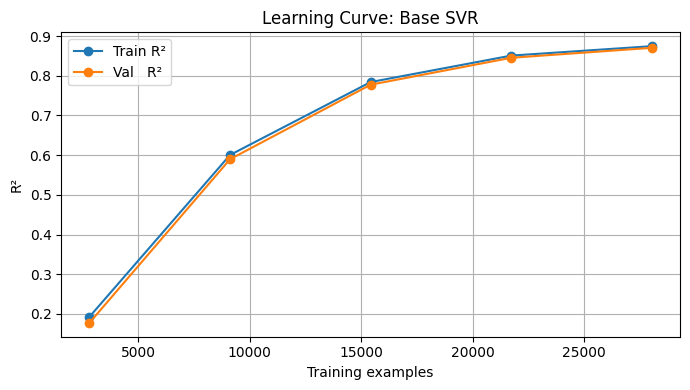

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Tuned SVR params: {'C': 10, 'epsilon': 0.2, 'gamma': 'scale'}
Tuned SVR → R²: 0.956, RMSE: 19.53, MAE: 10.36


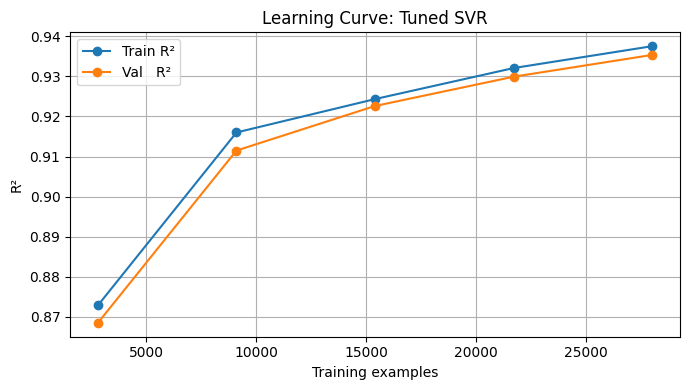

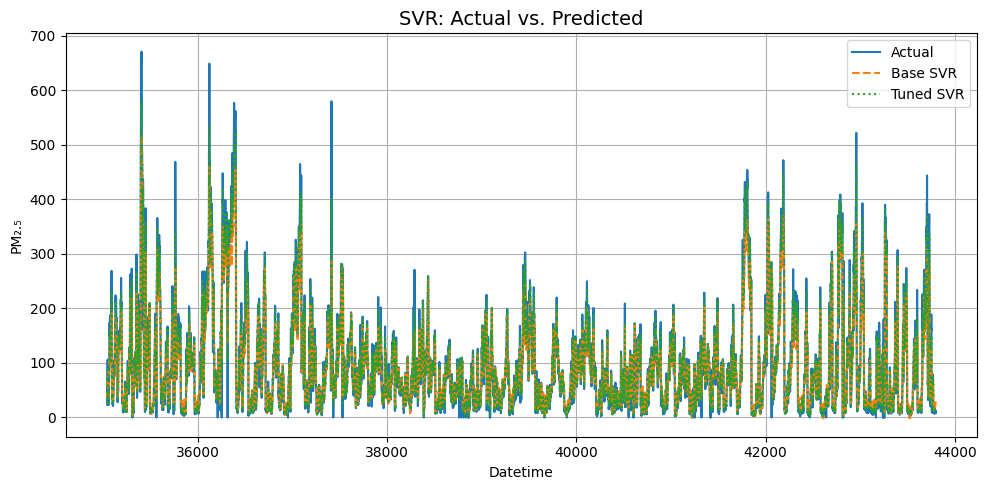

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# — Assumes X_train, X_test, y_train, y_test are already defined —

# 1) Base SVR
base_svr = SVR(kernel='rbf')  
base_svr.fit(X_train, y_train)
y_base = base_svr.predict(X_test)

# 2) Evaluate Base SVR
r2_base   = r2_score(y_test, y_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_base))
mae_base  = mean_absolute_error(y_test, y_base)
print(f"Base SVR → R²: {r2_base:.3f}, RMSE: {rmse_base:.2f}, MAE: {mae_base:.2f}")

# 3) Learning Curve: Base SVR
train_sizes, tr_scores, val_scores = learning_curve(
    base_svr, X_train, y_train,
    cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1, shuffle=True, random_state=42
)
plt.figure(figsize=(7,4))
plt.plot(train_sizes, tr_scores.mean(axis=1), 'o-', label='Train R²')
plt.plot(train_sizes, val_scores.mean(axis=1),   'o-', label='Val   R²')
plt.title("Learning Curve: Base SVR")
plt.xlabel("Training examples")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Grid-search to “undo” a bit of overfitting
param_grid = {
    'C':       [0.1, 1, 10],
    'gamma':   ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5]
}
grid_svr = GridSearchCV(
    SVR(kernel='rbf'),
    param_grid, cv=3, scoring='r2',
    n_jobs=-1, verbose=1
)
grid_svr.fit(X_train, y_train)
tuned_svr = grid_svr.best_estimator_
print("Tuned SVR params:", grid_svr.best_params_)

# 5) Evaluate Tuned SVR
y_tuned   = tuned_svr.predict(X_test)
r2_tuned  = r2_score(y_test, y_tuned)
rmse_tuned= np.sqrt(mean_squared_error(y_test, y_tuned))
mae_tuned = mean_absolute_error(y_test, y_tuned)
print(f"Tuned SVR → R²: {r2_tuned:.3f}, RMSE: {rmse_tuned:.2f}, MAE: {mae_tuned:.2f}")

# 6) Learning Curve: Tuned SVR
ts, tr_t, val_t = learning_curve(
    tuned_svr, X_train, y_train,
    cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1, shuffle=True, random_state=42
)
plt.figure(figsize=(7,4))
plt.plot(ts, tr_t.mean(axis=1), 'o-', label='Train R²')
plt.plot(ts, val_t.mean(axis=1),   'o-', label='Val   R²')
plt.title("Learning Curve: Tuned SVR")
plt.xlabel("Training examples")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7) Actual vs. Predicted (Base vs. Tuned)
dt_index = y_test.index  # if datetime indexed
plt.figure(figsize=(10,5))
plt.plot(dt_index, y_test,      label='Actual',    color='tab:blue')
plt.plot(dt_index, y_base,      '--', label='Base SVR',  color='tab:orange')
plt.plot(dt_index, y_tuned,     ':',  label='Tuned SVR', color='tab:green')
plt.title('SVR: Actual vs. Predicted', fontsize=14)
plt.xlabel('Datetime')
plt.ylabel('PM₂.₅')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


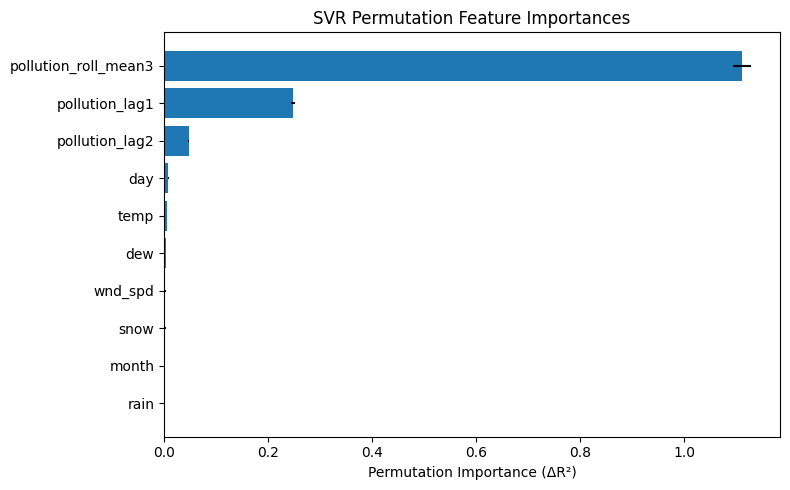

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR

# — assume X_train, X_test, y_train, y_test are already defined —

# 1) Train your tuned SVR (or load it if you already have it)
svr = SVR(kernel='rbf', C=10, gamma=0.01)   # use your tuned hyperparameters
svr.fit(X_train, y_train)

# 2) Compute permutation importances on the test set
result = permutation_importance(
    svr, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring='r2'
)

# 3) Sort features by importance
importances = result.importances_mean
stds        = result.importances_std
indices     = np.argsort(importances)[::-1]

# 4) Plot the top 10
top_n = 10
plt.figure(figsize=(8,5))
plt.barh(
    np.arange(top_n)[::-1],
    importances[indices][:top_n],
    xerr=stds[indices][:top_n],
    align='center'
)
plt.yticks(
    np.arange(top_n)[::-1],
    X_train.columns[indices][:top_n]
)
plt.xlabel("Permutation Importance (ΔR²)")
plt.title("SVR Permutation Feature Importances")
plt.tight_layout()
plt.show()


RF

Base RF → R²: 0.957, RMSE: 19.44, MAE: 10.92


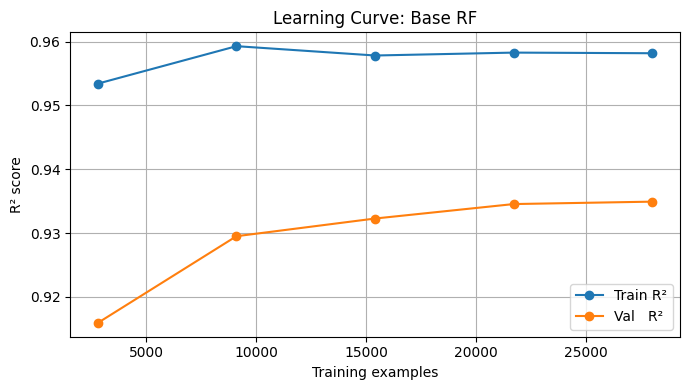

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Tuned RF params: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 300}
Tuned RF → R²: 0.996, RMSE: 6.11, MAE: 2.22


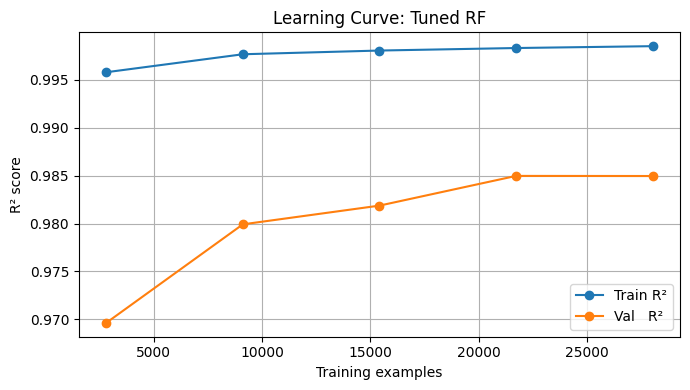

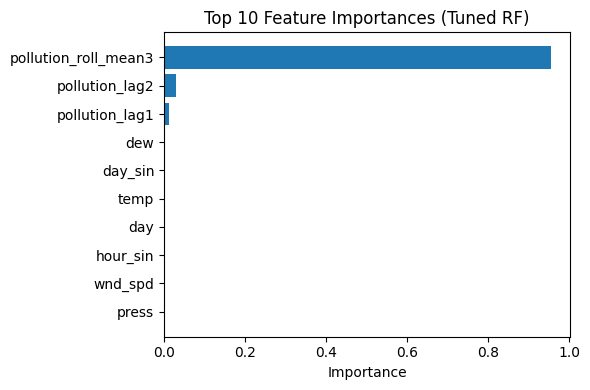

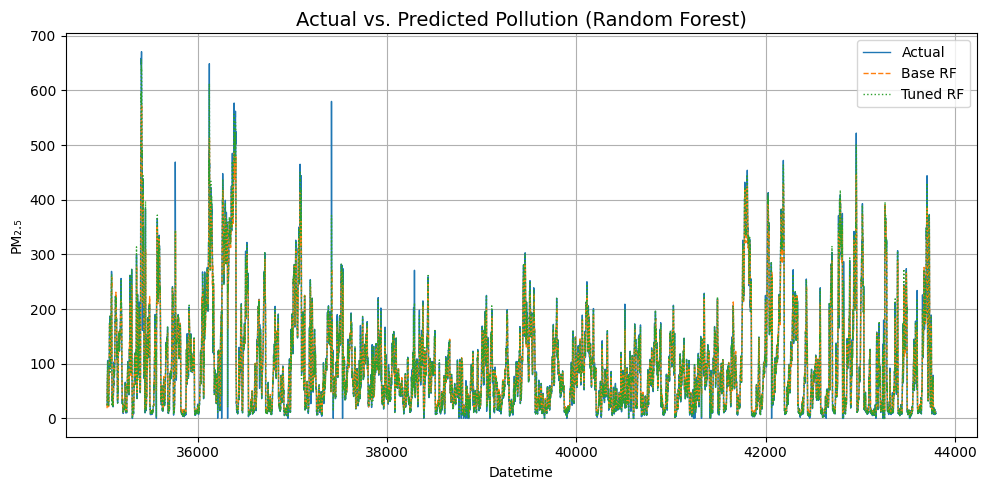

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ── Assumes X_train, X_test, y_train, y_test are already defined ────────────

# 1) Base RF with regularization
base_rf = RandomForestRegressor(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    max_features='sqrt'
)
base_rf.fit(X_train, y_train)
y_pred_base = base_rf.predict(X_test)

# 2) Evaluate Base RF
r2_base = r2_score(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
mae_base = mean_absolute_error(y_test, y_pred_base)
print(f"Base RF → R²: {r2_base:.3f}, RMSE: {rmse_base:.2f}, MAE: {mae_base:.2f}")

# 3) Learning curve for Base RF
train_sizes, train_scores, val_scores = learning_curve(
    base_rf, X_train, y_train,
    cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1, shuffle=True, random_state=42
)
plt.figure(figsize=(7,4))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train R²')
plt.plot(train_sizes, val_scores.mean(axis=1),   'o-', label='Val   R²')
plt.title("Learning Curve: Base RF")
plt.xlabel("Training examples")
plt.ylabel("R² score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Hyperparameter tuning for Tuned RF
param_grid = {
    'n_estimators':    [100, 200, 300],
    'max_depth':       [None, 15, 25],
    'min_samples_leaf':[1, 3, 5],
    'max_features':    ['sqrt', 'log2', None]
}
grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1
)
grid_rf.fit(X_train, y_train)
tuned_rf = grid_rf.best_estimator_
print("Tuned RF params:", grid_rf.best_params_)

# 5) Evaluate Tuned RF
y_pred_tuned = tuned_rf.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
print(f"Tuned RF → R²: {r2_tuned:.3f}, RMSE: {rmse_tuned:.2f}, MAE: {mae_tuned:.2f}")

# 6) Learning curve for Tuned RF
ts, tr_scores_t, val_scores_t = learning_curve(
    tuned_rf, X_train, y_train,
    cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1, shuffle=True, random_state=42
)
plt.figure(figsize=(7,4))
plt.plot(ts, tr_scores_t.mean(axis=1), 'o-', label='Train R²')
plt.plot(ts, val_scores_t.mean(axis=1),   'o-', label='Val   R²')
plt.title("Learning Curve: Tuned RF")
plt.xlabel("Training examples")
plt.ylabel("R² score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7) Feature importances (top 10) for Tuned RF
importances = tuned_rf.feature_importances_
idx = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(6,4))
plt.barh(range(10), importances[idx][::-1], align='center')
plt.yticks(range(10), X_train.columns[idx][::-1])
plt.title("Top 10 Feature Importances (Tuned RF)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 8) Overlay Actual vs. Predicted for Base and Tuned RF
dt_index = y_test.index  # datetime index
plt.figure(figsize=(10,5))
plt.plot(dt_index, y_test,           label='Actual',        color='tab:blue',   linewidth=1)
plt.plot(dt_index, y_pred_base,     '--', label='Base RF',      color='tab:orange', linewidth=1)
plt.plot(dt_index, y_pred_tuned,    ':',  label='Tuned RF',     color='tab:green',  linewidth=1)
plt.title('Actual vs. Predicted Pollution (Random Forest)', fontsize=14)
plt.xlabel('Datetime')
plt.ylabel('PM₂.₅')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()



Comparison

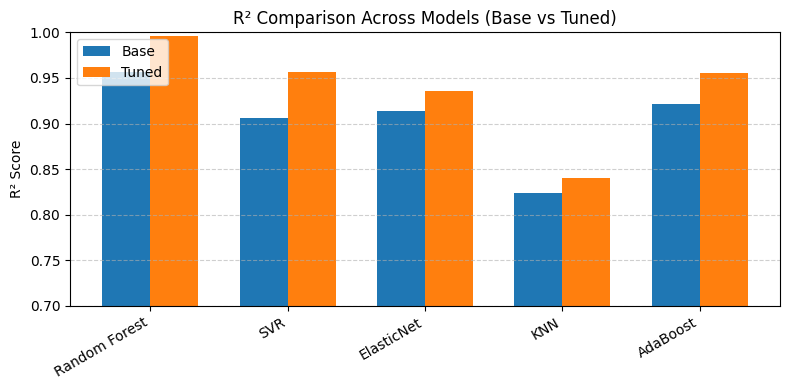

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Replace these with your actual R² results:
models = ['Random Forest', 'SVR', 'ElasticNet', 'KNN', 'AdaBoost']
r2_base  = [0.957, 0.906, 0.914, 0.824, 0.921]  # Base‐model R² values
r2_tuned = [0.996, 0.956, 0.936, 0.840, 0.955]  # Tuned‐model R² values

# 2) Plot
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x - width/2, r2_base,  width, label='Base',  color='C0')
ax.bar(x + width/2, r2_tuned, width, label='Tuned', color='C1')

# 3) Labels & styling
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha='right')
ax.set_ylabel('R² Score')
ax.set_ylim(0.7,1.0)
ax.set_title('R² Comparison Across Models (Base vs Tuned)')
ax.legend(loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
